<a href="https://colab.research.google.com/github/BhoomiMahna/outfit-vibe-rater/blob/main/project_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Unzipping data from /content/drive/MyDrive/Colab Datasets/outfits_final.zip...
✅ Files extracted to 'outfits_final' folder.

Loading models and datasets...


Found 884 files belonging to 2 classes.
Using 176 files for validation.
Found 1277 files belonging to 3 classes.
Using 255 files for validation.
Found 830 files belonging to 2 classes.
Using 166 files for validation.
✅ Models and datasets loaded.

Generating ROC data for all models...
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ ROC data generated.

Plotting combined ROC curves...


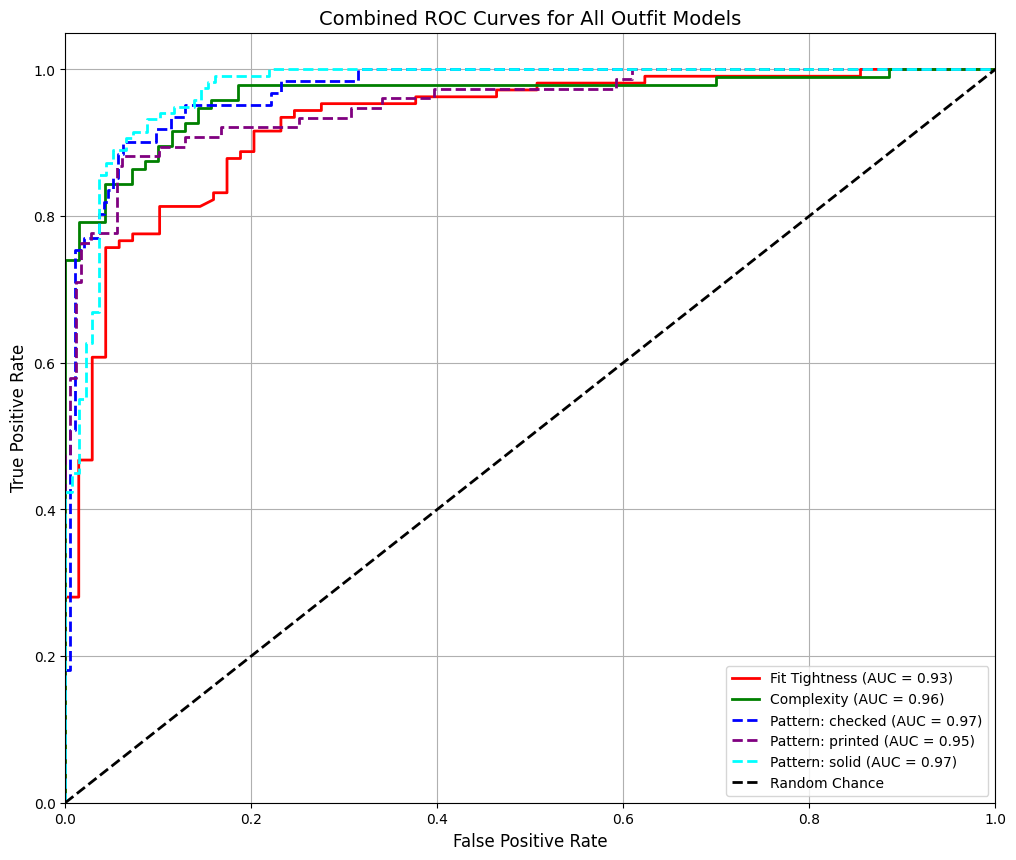

In [ ]:
import zipfile
import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from google.colab import drive

# --- 1. Connect to Google Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive')

# --- 2. Unzip Data from Google Drive ---
zip_path = '/content/drive/MyDrive/Colab Datasets/outfits_final.zip' # 👈 Make sure this path is correct
extract_path = 'outfits_final'

print(f"\nUnzipping data from {zip_path}...")
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Files extracted to '{extract_path}' folder.")
else:
    print("✅ Files already extracted.")


# --- 3. SETUP: Define paths and model names ---
data_folder = 'outfits_final/outfits/'
models_folder = '/content/drive/MyDrive/Colab Models/' # 👈 Make sure this is where you saved your models

# Paths to your data categories
path_fit = os.path.join(data_folder, 'fit tightness')
path_pattern = os.path.join(data_folder, 'pattern density')
path_complexity = os.path.join(data_folder, 'complexity')

# Paths to your saved models in Google Drive
model_path_fit = os.path.join(models_folder, 'fit_tightness_best_model.h5')
model_path_pattern = os.path.join(models_folder, 'pattern_density_best_model.h5')
model_path_complexity = os.path.join(models_folder, 'complexity_best_model.h5')

# Image sizes used for each model
img_size = (260, 260)

# --- 4. Load the Models and Datasets ---
print("\nLoading models and datasets...")
model_fit = tf.keras.models.load_model(model_path_fit)
model_pattern = tf.keras.models.load_model(model_path_pattern)
model_complexity = tf.keras.models.load_model(model_path_complexity)

val_ds_fit = tf.keras.utils.image_dataset_from_directory(
    path_fit, validation_split=0.2, subset='validation', seed=42, image_size=img_size, label_mode='categorical')
val_ds_pattern = tf.keras.utils.image_dataset_from_directory(
    path_pattern, validation_split=0.2, subset='validation', seed=42, image_size=img_size, label_mode='categorical')
val_ds_complexity = tf.keras.utils.image_dataset_from_directory(
    path_complexity, validation_split=0.2, subset='validation', seed=42, image_size=img_size, label_mode='categorical')
print("✅ Models and datasets loaded.")

# --- 5. Function to Get ROC Data ---
def get_roc_data(model, val_ds):
    y_true = []
    y_pred_probs = []
    for images, labels in val_ds:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images))

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    n_classes = y_true.shape[1]
    class_names = val_ds.class_names
    roc_data = {}

    if n_classes == 2: # Binary classification
        true_labels = np.argmax(y_true, axis=-1)
        pred_scores = y_pred_probs[:, 1]
        fpr, tpr, _ = roc_curve(true_labels, pred_scores)
        roc_auc = auc(fpr, tpr)
        roc_data['main'] = (fpr, tpr, roc_auc)
    else: # Multi-class classification
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            roc_data[class_names[i]] = (fpr, tpr, roc_auc)

    return roc_data

# --- 6. Generate ROC Data for All Models ---
print("\nGenerating ROC data for all models...")
roc_fit = get_roc_data(model_fit, val_ds_fit)
roc_pattern = get_roc_data(model_pattern, val_ds_pattern)
roc_complexity = get_roc_data(model_complexity, val_ds_complexity)
print("✅ ROC data generated.")

# --- 7. Plot All Curves on One Graph ---
print("\nPlotting combined ROC curves...")
plt.figure(figsize=(12, 10))

# Plot binary models with solid lines
fpr, tpr, roc_auc = roc_fit['main']
plt.plot(fpr, tpr, lw=2, color='red', label=f'Fit Tightness (AUC = {roc_auc:.2f})')

fpr, tpr, roc_auc = roc_complexity['main']
plt.plot(fpr, tpr, lw=2, color='green', label=f'Complexity (AUC = {roc_auc:.2f})')

# Plot multi-class model with dashed lines
colors = cycle(['blue', 'purple', 'cyan'])
for (class_name, (fpr, tpr, roc_auc)), color in zip(roc_pattern.items(), colors):
    plt.plot(fpr, tpr, lw=2, linestyle='--', color=color, label=f'Pattern: {class_name} (AUC = {roc_auc:.2f})')

# Plot the "random chance" line and format the graph
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Combined ROC Curves for All Outfit Models', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Loading models from Google Drive...


✅ Models loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

--- Outfit Analysis ---
Fit Tightness: Baggy
Complexity: Single Layer
Pattern Density: Solid
-----------------------
Overall Vibe: You're classy! (33/100)
-----------------------


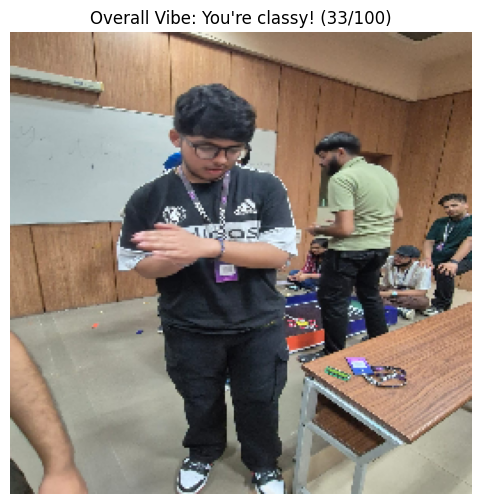

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# --- 1. SETUP: Load all three trained models from your Drive ---
print("Loading models from Google Drive...")
models_folder = '/content/drive/MyDrive/Colab Models/' # 👈 Make sure this is where your models are

model_fit = tf.keras.models.load_model(os.path.join(models_folder, 'fit_tightness_best_model.h5'))
model_pattern = tf.keras.models.load_model(os.path.join(models_folder, 'pattern_density_best_model.h5'))
model_complexity = tf.keras.models.load_model(os.path.join(models_folder, 'complexity_best_model.h5'))

# Define the class names for each model in the correct order
fit_class_names = ['baggy', 'tight']
pattern_class_names = ['checked', 'printed', 'solid']
complexity_class_names = ['multilayer', 'single layer']

# Define the image size the models were trained on
img_size = (260, 260)
print("✅ Models loaded successfully.")

# --- 2. PREDICTION FUNCTION ---
def get_outfit_predictions(image_path):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    preprocessed_img = tf.keras.applications.efficientnet_v2.preprocess_input(img_batch)

    pred_fit = model_fit.predict(preprocessed_img)
    pred_pattern = model_pattern.predict(preprocessed_img)
    pred_complexity = model_complexity.predict(preprocessed_img)

    fit_label = fit_class_names[np.argmax(pred_fit)]
    pattern_label = pattern_class_names[np.argmax(pred_pattern)]
    complexity_label = complexity_class_names[np.argmax(pred_complexity)]

    return {
        "fit": fit_label,
        "pattern": pattern_label,
        "complexity": complexity_label
    }, img

# --- 3. SCORING FUNCTION ---
def calculate_vibe_score(predictions):
    total_score = 0.0

    if predictions['fit'] == 'baggy':
        total_score += 33.3

    if predictions['complexity'] == 'multilayer':
        total_score += 33.3

    if predictions['pattern'] == 'printed':
        total_score += 33.3
    elif predictions['pattern'] == 'checked':
        total_score += 16.7

    score_int = int(round(total_score))
    if score_int > 75:
        vibe = f"You're too cool! ({score_int}/100)"
    elif score_int > 40:
        vibe = f"In between cool and classy. ({score_int}/100)"
    else:
        vibe = f"You're classy! ({score_int}/100)"

    return score_int, vibe

# --- 4. TEST ON A NEW IMAGE ---
# 👈 Change this to the path of an image in your Google Drive
image_to_test = '/content/drive/MyDrive/Colab Datasets/hoo.jpg'

try:
    predictions, image_to_display = get_outfit_predictions(image_to_test)
    score, vibe = calculate_vibe_score(predictions)

    # --- 5. DISPLAY THE FINAL RESULT ---
    print("\n--- Outfit Analysis ---")
    print(f"Fit Tightness: {predictions['fit'].title()}")
    print(f"Complexity: {predictions['complexity'].title()}")
    print(f"Pattern Density: {predictions['pattern'].title()}")
    print("-----------------------")
    print(f"Overall Vibe: {vibe}")
    print("-----------------------")

    plt.figure(figsize=(6, 6))
    plt.imshow(image_to_display)
    plt.title(f"Overall Vibe: {vibe}")
    plt.axis("off")
    plt.show()

except FileNotFoundError:
    print(f"❌ ERROR: File not found at '{image_to_test}'. Please check the path and try again.")

In [ ]:
# Make sure your Google Drive is mounted first
# from google.colab import drive
# drive.mount('/content/drive')

# 1. Define the path where you want to save the model in your Drive
#    Let's use the 'fit tightness' model as an example.
#    Using the .keras format is the modern recommendation.
save_path = "/content/drive/MyDrive/Colab Models/fit_tightness_final.keras"

# 2. Save the trained 'model' object that is currently in your session
#    This command saves the architecture, weights, and optimizer state.
model.save(save_path)

print(f"✅ Model successfully saved to:{save_path}")